# Regression Modelling

Preprocess Data & Run Regression Algorithms to determine the importance / success of different promotions for different customer segments.


### Data Sources

Cleaned datafile, as prepared in notebook 1:
- profile_long_clean.csv - demographic data, offer data and transaction data for each customer

### Changes

- 2019-01-10: Started notebook



In [1]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel 

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # for error calculation of feature weights

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [40]:
# import data

profile_file = Path.cwd() / "data" / "processed" / "profile_long_clean.csv"
profile = pd.read_csv(profile_file, index_col = 0)

## Check profile (long) data

In [3]:
display(profile.head())
display(profile.info())

,age,gender,income,member_days,"('o_1', 'offer received')","('o_1', 'offer viewed')","('o_1', 'offer completed')","('o_1', 'transactions')","('o_2', 'offer received')","('o_2', 'offer viewed')","('o_2', 'offer completed')","('o_2', 'transactions')","('o_3', 'offer received')","('o_3', 'offer viewed')","('o_3', 'offer completed')","('o_3', 'transactions')","('o_4', 'offer received')","('o_4', 'offer viewed')","('o_4', 'offer completed')","('o_4', 'transactions')","('o_5', 'offer received')","('o_5', 'offer viewed')","('o_5', 'offer completed')","('o_5', 'transactions')","('o_6', 'offer received')","('o_6', 'offer viewed')","('o_6', 'offer completed')","('o_6', 'transactions')","('o_7', 'offer received')","('o_7', 'offer viewed')","('o_7', 'offer completed')","('o_7', 'transactions')","('o_8', 'offer received')","('o_8', 'offer viewed')","('o_8', 'offer completed')","('o_8', 'transactions')","('o_9', 'offer received')","('o_9', 'offer viewed')","('o_9', 'offer completed')","('o_9', 'transactions')","('o_10', 'offer received')","('o_10', 'offer viewed')","('o_10', 'offer completed')","('o_10', 'transactions')",total_amount
p_1,NaN,NaN,NaN,-529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.40
p_10,NaN,NaN,NaN,-611,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,15.62
p_100,68.0,F,84000.0,-725,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.04
p_1000,67.0,M,44000.0,-225,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,19.78
p_10000,NaN,NaN,NaN,-446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.28


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 45 columns):
age                            14825 non-null float64
gender                         14825 non-null object
income                         14825 non-null float64
member_days                    17000 non-null int64
('o_1', 'offer received')      17000 non-null float64
('o_1', 'offer viewed')        17000 non-null float64
('o_1', 'offer completed')     17000 non-null float64
('o_1', 'transactions')        17000 non-null float64
('o_2', 'offer received')      17000 non-null float64
('o_2', 'offer viewed')        17000 non-null float64
('o_2', 'offer completed')     17000 non-null float64
('o_2', 'transactions')        17000 non-null float64
('o_3', 'offer received')      17000 non-null float64
('o_3', 'offer viewed')        17000 non-null float64
('o_3', 'offer completed')     17000 non-null float64
('o_3', 'transactions')        17000 non-null float64
('o_4', 'offer received')      1

None

In [4]:
# """eliminiate missing values"""

# profile = cleaning.handle_NaN(profile, cols_to_impute_num=['age', 'income'])
# profile['gender'] = profile['gender'].fillna('u')

In [5]:
# check results
# profile.head()

## Run quick and dirty linear regression

In [6]:
"initialize and run base model"

# define a scikit-learn model object you want to work with
model = LinearRegression(normalize=True)
# create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
linReg_simple = LinRegModel(profile, 'total_amount', model)
# go
linReg_simple.go_quickDirty()

In [7]:
# check performance
linReg_simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

RMSE on test data 97.29, r2-score 0.42.

[learning_curve] Training set sizes: [  95  591 1087 1583 2079 2575 3071 3567 4063 4559 5055 5551 6047 6543
 7039 7535 8031 8527 9023 9520]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


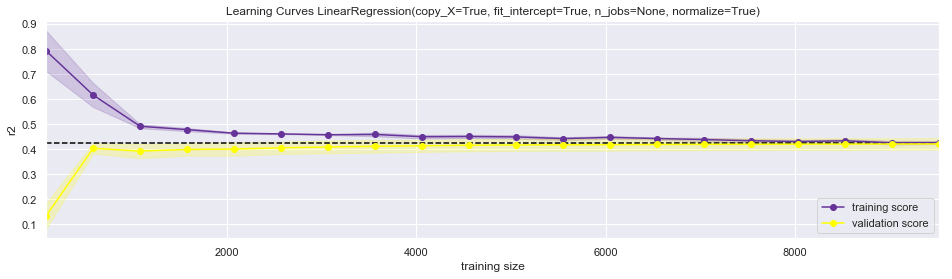

In [8]:
"""plot learning curves using 5-fold cross validation"""
linReg_simple.plot_learning_curves()

### Check results for Ridge, Lasso, ElasticNet

In [9]:
# define RidgeCV without normalization but higher alphas)
model = RidgeCV(alphas=[30, 50, 70], cv=3, fit_intercept=True)
# instantiate
ridgeCV_simple = LinRegModel(profile, 'total_amount', model)
# perform linear regression modelling
ridgeCV_simple.go_quickDirty()
# output scores
ridgeCV_simple

RidgeCV(alphas=array([30, 50, 70]), cv=3, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

RMSE on test data 97.30, r2-score 0.42.

In [10]:
model.alpha_

50

In [11]:
# plot feature weights
# ridgeCV_simple.print_coef_weights(n_bootstrap=10)

In [12]:
# define lassoCV without normalization (but higher alphas)
model = LassoCV(alphas=[0.01, 0.1, 1],cv=3, fit_intercept=True)
# instantiate
lassoCV_simple = LinRegModel(profile, 'total_amount', model)
# perform linear regression modelling
lassoCV_simple.go_quickDirty()
# output scores
lassoCV_simple

LassoCV(alphas=[0.01, 0.1, 1], copy_X=True, cv=3, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

RMSE on test data 97.31, r2-score 0.42.

In [13]:
model.alpha_

0.1

In [46]:
# plot feature weights
lassoCV_simple.print_coef_weights(n_bootstrap=10)

,effect,error
"('o_1', 'offer completed')",49.5,0.0
"('o_2', 'offer completed')",46.7,0.0
gender_nan,-38.6,0.0
"('o_4', 'offer completed')",36.1,4.0
"('o_8', 'offer completed')",31.2,4.0
"('o_5', 'offer completed')",29.9,3.0
"('o_7', 'offer completed')",27.6,1.0
"('o_3', 'offer completed')",24.6,4.0
"('o_6', 'offer completed')",19.8,4.0
"('o_1', 'offer received')",-19.0,3.0


In [15]:
# define ElasticNetCV without normalization
model = ElasticNetCV(alphas=[0.05, 0.1, 0.2], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1)
# instantiate
elasticNetCV_simple = LinRegModel(profile, 'total_amount', model)
# perform linear regression modelling on instance
elasticNetCV_simple.go_quickDirty()
# output scores
elasticNetCV_simple

ElasticNetCV(alphas=[0.05, 0.1, 0.2], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=[0.2, 0.5, 0.7], max_iter=1000,
       n_alphas=None, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

RMSE on test data 97.40, r2-score 0.41.

In [16]:
print(model.alpha_)
print(model.l1_ratio_)

0.05
0.7


In [17]:
# plot feature weights
# elasticNetCV_simple.print_coef_weights(n_bootstrap=10)

## Second approach with proper data preparation

In [41]:
"""eliminate outliers"""

# count outliers
cleaning.count_outliers_IQR_method(profile, IQR_dist=1.5)

age
Identified outliers: 0
Percentage of outliers: 0.0%

income
Identified outliers: 0
Percentage of outliers: 0.0%

member_days
Identified outliers: 287
Percentage of outliers: 1.7%

('o_1', 'offer received')
Identified outliers: 122
Percentage of outliers: 0.7%

('o_1', 'offer viewed')
Identified outliers: 91
Percentage of outliers: 0.5%

('o_1', 'offer completed')
Identified outliers: 3147
Percentage of outliers: 18.5%

('o_1', 'transactions')
Identified outliers: 2993
Percentage of outliers: 17.6%

('o_2', 'offer received')
Identified outliers: 111
Percentage of outliers: 0.7%

('o_2', 'offer viewed')
Identified outliers: 92
Percentage of outliers: 0.5%

('o_2', 'offer completed')
Identified outliers: 2834
Percentage of outliers: 16.7%

('o_2', 'transactions')
Identified outliers: 2249
Percentage of outliers: 13.2%

('o_3', 'offer received')
Identified outliers: 128
Percentage of outliers: 0.8%

('o_3', 'offer viewed')
Identified outliers: 3616
Percentage of outliers: 21.3%

('o_3'

In [42]:
# remove oultiers
outlier_cols = ['total_amount']
cleaning.remove_outliers_IQR_method(profile, outlier_cols=outlier_cols, IQR_dist=1.5)

total_amount
Rows removed: 521


Rows removed in total: 521



In [43]:
# instantiate
elasticNetCV_simple = LinRegModel(profile, 'total_amount', model)
# perform linear regression modelling on instance
elasticNetCV_simple.go_quickDirty()
# output scores
elasticNetCV_simple

ElasticNetCV(alphas=[0.05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

RMSE on test data 43.46, r2-score 0.70.

In [44]:
print(model.alpha_)
print(model.l1_ratio_)

0.05
0.7


In [45]:
elasticNetCV_simple.print_coef_weights(n_bootstrap=10)

,effect,error
"('o_1', 'offer completed')",36.2,0.0
"('o_2', 'offer completed')",35.0,0.0
gender_nan,-32.4,0.0
"('o_4', 'offer completed')",26.5,1.0
"('o_5', 'offer completed')",25.4,1.0
"('o_3', 'offer completed')",24.0,1.0
"('o_8', 'offer completed')",23.8,0.0
"('o_7', 'offer completed')",21.7,1.0
"('o_6', 'offer completed')",19.1,1.0
"('o_1', 'offer received')",-15.2,1.0


[learning_curve] Training set sizes: [  92  573 1053 1534 2015 2496 2977 3458 3938 4419 4900 5381 5862 6343
 6823 7304 7785 8266 8747 9228]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished


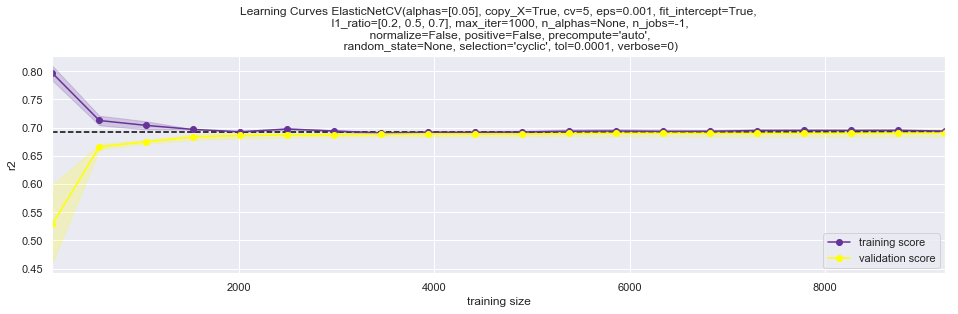

In [48]:
"""plot learning curves using 5-fold cross validation"""
elasticNetCV_simple.plot_learning_curves()

In [38]:
"""log transform"""

# cleaning.apply_log10(profile, cols_to_log10=['member_days'])

In [39]:
# # define ElasticNetCV without normalization
# model = ElasticNetCV(alphas=[0.05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
#        l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1)

# # instantiate
# elasticNetCV_simple = LinRegModel(profile, 'total_amount_log', model)
# # perform linear regression modelling on instance
# elasticNetCV_simple.go_quickDirty()
# # output scores
# elasticNetCV_simple

ElasticNetCV(alphas=[0.05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

RMSE on test data 0.34, r2-score 0.65.

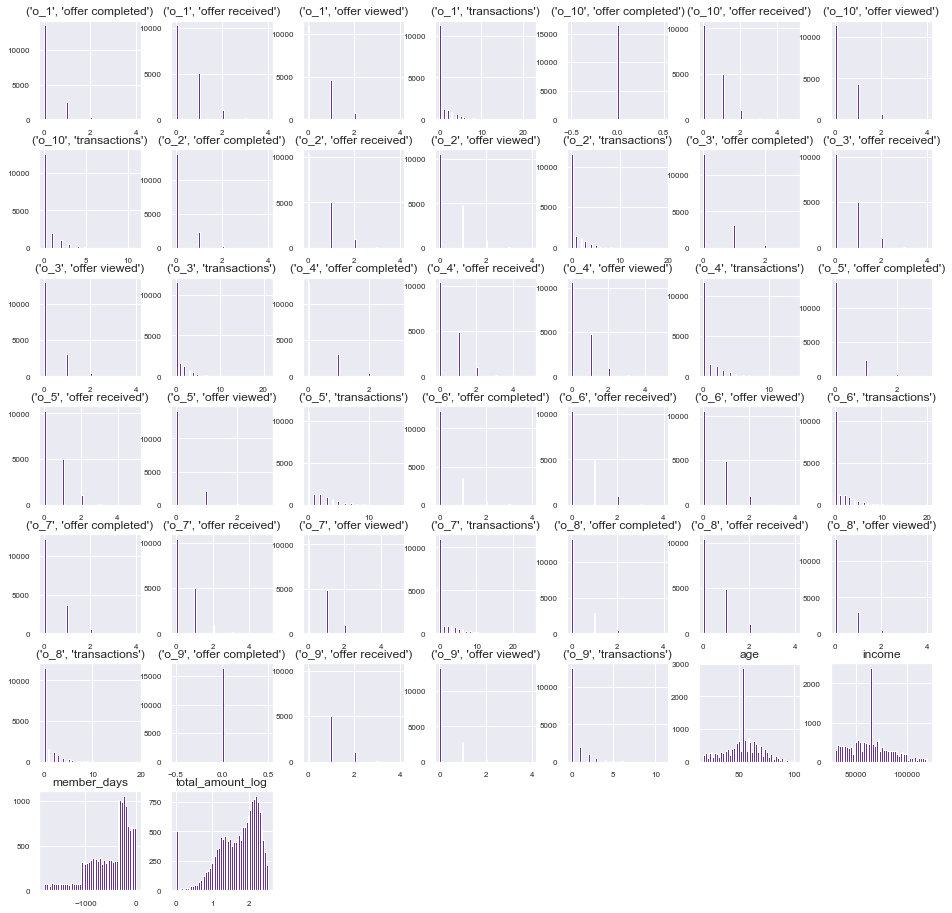

In [37]:
# check results
EDA.plot_num_hist(profile)